In [10]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle
plt.style.use('ggplot')

In [3]:
#http://powderlin.es/api.html for api information
snow_api = 'http://api.powderlin.es/'
stations = requests.get(snow_api+'stations')

In [4]:
# Importing stations
df_stations = pd.DataFrame.from_records(stations.json())
num_stations = df_stations.shape[0]

# Removing location for clean up
location = df_stations['location']
df_stations = df_stations.drop(columns=['location'])
num_stations = df_stations.shape[0]

# Cleaning up location
lat = []
lng = []
for i in location:
    lat.append(i['lat'])
    lng.append(i['lng'])

# Concatonating to df_stations
df_stations['lat'] = lat 
df_stations['lng'] = lng

# Results
print(f'There are {num_stations} stations in database.')
df_stations.head(15)

There are 867 stations in database.


,elevation,name,timezone,triplet,wind,lat,lng
0,8777,BEAR RIVER RS,-7,992:UT:SNTL,False,40.88520,-110.82770
1,5130,PARADISE,-8,679:WA:SNTL,False,46.78265,-121.74765
2,4890,GERBER RESERVOIR,-8,945:OR:SNTL,False,42.20620,-121.13340
3,9820,GUNSIGHT PASS,-7,944:WY:SNTL,False,43.38332,-109.87815
4,10966,LAKEFORK BASIN,-7,567:UT:SNTL,False,40.73783,-110.62087
5,7850,BEAVER CREEK,-7,328:MT:SNTL,False,44.94966,-111.35852
6,8968,CAMP JACKSON,-7,383:UT:SNTL,False,37.81333,-109.48723
7,6780,PATTON MEADOWS AM,-8,1241:OR:SNTLT,False,42.24522,-120.60527
8,9105,SQUAW SPRINGS,-7,1156:UT:SNTL,False,38.49730,-112.00789
9,6720,PINE CREEK PASS,-7,695:ID:SNTL,False,43.56998,-111.21157


In [5]:
#find stations in CO
CO=[]
for i in range(num_stations):
    if 'CO' in df_stations['triplet'][i]:
        CO.append(i)

df_CO_stations = pd.DataFrame(df_stations.loc[CO,:])

print(f'There are {len(CO)} stations in Colorado with the following indices:')
df_CO_stations

There are 113 stations in Colorado with the following indices:


,elevation,name,timezone,triplet,wind,lat,lng
23,10700,WILLOW PARK,-7,870:CO:SNTL,False,40.43254,-105.73337
30,11580,BLACK MESA,-7,1185:CO:SNTL,False,37.78972,-108.18365
33,10200,LIZARD HEAD PASS,-7,586:CO:SNTL,False,37.79926,-107.92426
36,10000,MANCOS,-7,905:CO:SNTL,False,37.43087,-108.16954
38,11000,WOLF CREEK SUMMIT,-7,874:CO:SNTL,False,37.47922,-106.80170
...,...,...,...,...,...,...,...
829,10760,PORPHYRY CREEK,-7,701:CO:SNTL,False,38.48884,-106.33965
830,11100,WAGER GULCH,-7,1188:CO:SNTL,True,37.88248,-107.36430
853,10500,MOLAS LAKE,-7,632:CO:SNTL,False,37.74932,-107.68866
854,10000,MESA LAKES,-7,622:CO:SNTL,False,39.05831,-108.05835


In [6]:
# scrape only CO sites

num_days = 3652
CO_station_data = {}


for i in CO:

    #if 'CO' in df_stations['triplet'][i]:
        try: 
            # Grab individual site
            site = requests.get(snow_api + 'station/' + stations.json()[i]['triplet'], params={'days':num_days}).json() 

            # Extracting the data and storing it into a dataframe
            data = site['data']
            CO_df = pd.DataFrame.from_records(data)
          
            
            # Storing individual site into a dictionary
            CO_station_data[df_stations['name'][i]] = CO_df
            
        except ValueError:

            # Don't store station if it throws a ValueError (JSONDecodeError in this case)
            print(f'Station: {df_stations["name"][i]} (Index: {i}) is no longer supported (Internal Server Error).')
#CO_station_data

In [37]:
# missing data?

#dfObj = pd.DataFrame(list(CO_stations.items()))
#print(dfObj)
# show the boolean dataframe            
#print(" \nshow the boolean Dataframe : \n\n", dfObj.isnull())
  
# Count total NaN in a DataFrame
#print(" \nCount total NaN in a DataFrame : \n\n", dfObj.isnull().sum().sum())

#count=0
#for i in range(num_days):
#    if CO_stations['UNIVERSITY CAMP']['Snow Depth (in)'][i] == 'None':
#        print(i)
#        count+=1
#print(count)  

In [7]:
#adding CO station data to df and filling NaN

df_CO = pd.DataFrame(CO_df['Date'])
for i in CO:
    if len(CO_station_data[df_CO_stations['name'][i]]) == num_days+1:
        CO_station_data_i = CO_station_data[df_CO_stations['name'][i]]

        df_CO['swe_%d' % i] = CO_station_data_i['Snow Water Equivalent (in)'].fillna(method='ffill')
        df_CO['cswe_%d' % i] = CO_station_data_i['Change In Snow Water Equivalent (in)'].fillna(0)
        df_CO['sd_%d' % i] = CO_station_data_i['Snow Depth (in)'].fillna(method='ffill')
        df_CO['csd_%d' % i] = CO_station_data_i['Change In Snow Depth (in)'].fillna(0)
        df_CO['oat_%d' % i] = CO_station_data_i['Observed Air Temperature (degrees farenheit)'].fillna(method='ffill')

print(f'There are {(df_CO.shape[1]-1)/5} stations in Colorado with enough data for those dates:')
df_CO      

There are 106.0 stations in Colorado with enough data for those dates:


,Date,swe_23,cswe_23,sd_23,csd_23,oat_23,swe_33,cswe_33,sd_33,csd_33,...,swe_854,cswe_854,sd_854,csd_854,oat_854,swe_866,cswe_866,sd_866,csd_866,oat_866
0,2011-04-21,33.4,0.5,86,-1,32,11.6,-0.5,27,-2,...,23.3,-0.1,57,-5,38,0.0,0.0,0,0,45
1,2011-04-22,34.2,0.8,93,7,21,10.8,-0.8,25,-2,...,23.8,0.5,61,4,27,0.0,0.0,0,0,41
2,2011-04-23,34.7,0.5,92,-1,22,10.4,-0.4,24,-1,...,23.6,-0.2,60,-1,28,0.0,0.0,0,0,36
3,2011-04-24,35.4,0.7,92,0,26,10.7,0.3,29,5,...,24.2,0.6,64,4,29,0.3,0.3,2,2,37
4,2011-04-25,35.7,0.3,94,2,25,11.5,0.8,35,6,...,24.8,0.6,69,5,26,0.4,0.1,2,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2021-04-16,19.7,0.7,60,5,13,8.1,-0.3,19,-2,...,10.7,0.2,37,8,20,0.6,0.0,1,0,22
3649,2021-04-17,19.9,0.2,60,0,14,8.0,-0.1,22,3,...,10.9,0.2,37,0,22,0.8,0.2,1,0,17
3650,2021-04-18,19.9,0.0,56,0,5,8.0,0.0,23,1,...,11.1,0.2,37,0,13,1.4,0.6,10,0,12
3651,2021-04-19,20.1,0.2,55,-1,25,7.9,-0.1,22,-1,...,11.7,0.6,30,0,25,1.3,-0.1,3,-7,26


In [28]:
#output to csv

#df_CO.to_csv('df_CO.csv', index=False)

In [22]:
# Testing Individual Site
df_site = CO_station_data['UNIVERSITY CAMP']
df_site.tail(5)

,Date,Snow Water Equivalent (in),Change In Snow Water Equivalent (in),Snow Depth (in),Change In Snow Depth (in),Observed Air Temperature (degrees farenheit)
3648,2021-04-16,15.8,0.5,56,6,15
3649,2021-04-17,16.0,0.2,None,None,14
3650,2021-04-18,16.1,0.1,59,None,2
3651,2021-04-19,16.4,0.3,None,None,27
3652,2021-04-20,17.2,0.8,68,None,4


In [23]:
# Store features into their own dataframe and converting to numeric for plotting in order
dates = df_site['Date']
snow_water_equivalent = df_site['Snow Water Equivalent (in)'].apply(pd.to_numeric)
change_snow_water_equivalent = df_site['Change In Snow Water Equivalent (in)'].apply(pd.to_numeric)
snow_depth = df_site['Snow Depth (in)'].apply(pd.to_numeric)
change_snow_depth = df_site['Change In Snow Depth (in)'].apply(pd.to_numeric)
air_temp = df_site['Observed Air Temperature (degrees farenheit)'].apply(pd.to_numeric)


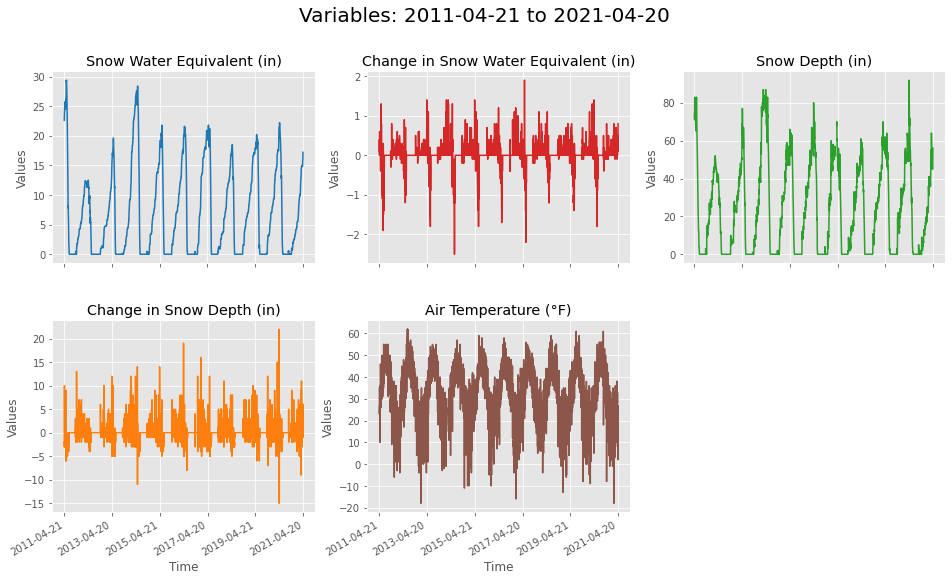

In [24]:
# Setting up figure
begin = df_site['Date'][0]
end = df_site['Date'][num_days]
fig, axs = plt.subplots(2, 3, figsize=(16,9))
fig.delaxes(axs[1,2])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
fig.suptitle('Variables: %s to %s' % (begin, end) , fontsize=20)

# Defining plot function
def plot(y, title, xlabel, ylabel, ax1, ax2, color):
    axs[ax1,ax2].plot(dates, y, c=color)
    axs[ax1,ax2].set_xlabel(xlabel)
    axs[ax1,ax2].set_ylabel(ylabel)
    axs[ax1,ax2].set_title(title)
    #axs[ax1,ax2].set_ylim([ymin, ymax])
    axs[ax1,ax2].set_xticks(np.arange(0, len(y)+1, (len(dates)-1)/5))
    #axs[ax1,ax2].set_yticks(np.arange(math.floor(float(min(y))), math.ceil(float(max(y))), 1.5))
    plt.gcf().autofmt_xdate()
   
    
# Plotting variables    
plot(snow_water_equivalent, 'Snow Water Equivalent (in)', 'Time', 'Values', 0, 0, 'tab:blue')
plot(change_snow_water_equivalent, 'Change in Snow Water Equivalent (in)', 'Time', 'Values', 0, 1, 'tab:red')
plot(snow_depth, 'Snow Depth (in)', 'Time', 'Values', 0, 2, 'tab:green')
plot(change_snow_depth, 'Change in Snow Depth (in)', 'Time', 'Values', 1, 0, 'tab:orange')
plot(air_temp, 'Air Temperature (°F)', 'Time', 'Values', 1, 1, 'tab:brown')

# ====== To Do ======
# Wrap our variables into an array so we can use add_subplot and a loop (removes redundant code)

In [25]:
#adding stations to the model
#stations_add = ['UNIVERSITY CAMP','NIWOT']

#for i in range(len(stations_add)):
    #df_site_i = station_data[stations_add[i]]

    #df_site['swe_%d' % i] = df_site_i['Snow Water Equivalent (in)'].apply(pd.to_numeric)
   # df_site['cswe_%d' % i] = df_site_i['Change In Snow Water Equivalent (in)'].apply(pd.to_numeric)
  #  df_site['sd_%d' % i] = df_site_i['Snow Depth (in)'].apply(pd.to_numeric)
 #   df_site['csd_%d' % i] = df_site_i['Change In Snow Depth (in)'].apply(pd.to_numeric)
#    df_site['oat_%d' % i] = df_site_i['Observed Air Temperature (degrees farenheit)'].apply(pd.to_numeric)
 
#df_site = df_site.fillna(0)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
 #   print(df_site)

In [30]:
%store dates
%store snow_water_equivalent
%store change_snow_water_equivalent
%store snow_depth
%store change_snow_depth
%store air_temp
%store df_site
%store df_CO

Stored 'dates' (Series)
Stored 'snow_water_equivalent' (Series)
Stored 'change_snow_water_equivalent' (Series)
Stored 'snow_depth' (Series)
Stored 'change_snow_depth' (Series)
Stored 'air_temp' (Series)
Stored 'df_site' (DataFrame)
Stored 'df_CO' (DataFrame)


In [8]:
LatLong = dict()
for i in CO:
    if len(CO_station_data[df_CO_stations['name'][i]]) == num_days+1:
        LatLong[i]= (df_CO_stations['lat'][i],df_CO_stations['lng'][i])

In [11]:
#save site data

afile = open("SnoLocations.pkl", 'wb')
pickle.dump(SnoLocations, afile)
afile.close()

NameError: name 'SnoLocations' is not defined